# Factor-based Risk Management

by Rene Zhang and

Part of the Quantopian Lecture Series:
* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [https://github.com/quantopian/research_public](https://github.com/quantopian/research_public)


Reference: 

Risk management is critical for constructing portfolios and building algos. It can help to improve the quality and consistency of returns, because the returns obtained by the unexpected risks, which are hiding within our portfolio, are usually not able to produce profits over a long time.  By limiting or eliminating the amount of these unexpected risks, ideally, the portfolio should only have the exposures to the alpha we pursue. In this lecture, we will focus on how to use factor model in risk management. 


Recall in the lecture of Factor Risk Exposure, we introduced the factor model that can be expressed as 


$$R_i = a_i + b_{i1} F_1 + b_{i2} F_2 + \ldots + b_{iK} F_k + \epsilon_i,$$

where:

$k$ $=$ the number of factors

$R_i$ $=$ the return for company $i$, 

$a_i$ $=$ the intercept,

$F_j$ $=$ the return for factor $j$, $j \in [1,k]$, 

$b_{ij}$ $=$ the corresponding exposure to factor $j$, $j \in [1,k]$, 

$\epsilon_i$ $=$ specific fluctuation of company $i$.


To quantify the unexpected risk (returns) and have an acceptable risk level, we will need to answer 3 questions:


1. What proportion of the variance of my portfolio comes from common risk factors?
      
2. How to limit the risk?
   
3. Performance attribution: where does the return/PNL come from?



The factors can be:
- fundamental factors, such as sector/industry factor and style factors (size, price-to-book (PB) ratio,
  momentum, volatiliy, etc.)
- Macroeconomic factor, such as market return and change in inflation 
- Statistical factors, that is purely based on historical returns and derived from principal component
  analysis


Examples:
    - Capital Asset Pricing Model(CAPM): market factor
    - Fama-French 3 Factor Model: market factor, size factor, and PB ratio factor
    - Barra's U.S. Equity model: industry factor and style factors

### Setup:


In [1]:
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels import regression
import matplotlib.pyplot as plt
import pandas as pd

#### Input parameters: 

In [2]:
# date range for building risk model
start = "2016-01-04"
end = "2016-06-06"


#### Define the universe of assets: 
The universe of assets we use here includes the [Q500US stocks](https://www.quantopian.com/posts/the-q500us-and-q1500us).

In [3]:
import numpy as np
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import CustomFactor, Returns
from quantopian.pipeline.filters.morningstar import Q500US
from quantopian.research import run_pipeline

In [4]:
# Include US500
def qus_returns(start_date, end_date):
    pipe = Pipeline(
        columns={'Close': USEquityPricing.close.latest},
        screen = Q500US()
    )
    stocks = run_pipeline(pipe, start_date, end_date)  
    unstacked_results = stocks.unstack()
    
    prices = (unstacked_results['Close'].fillna(method='ffill').fillna(method='bfill')
                  .dropna(axis=1,how='any').shift(periods=-1).dropna())  
    qus_returns = prices.pct_change()[1:]
    return qus_returns


R = qus_returns(start, end)
print "The universe we define includes {} assets.".format(R.shape[1])
print 'The number of timestamps is {} from {} to {}.'.format(R.shape[0], start, end)

The universe we define includes 536 assets.
The number of timestamps is 105 from 2016-01-04 to 2016-06-06.


In [5]:
assets = R.columns

#### Obtain the returns of factors and corresponding exposures:
Here, we use Fama-French factors as an example. The Fama-French factors are the market, company size, and company price-to-book (PB) ratio. We compute each asset's exposures to these factors.  The code to compute the factors using pipeline is borrowed from "Quantopian Lecture Series: Fundamental Factor Models" on [https://www.quantopian.com/lectures](https://www.quantopian.com/lectures).

In [6]:
class MarketCap(CustomFactor):
    # Here's the data we need for this factor
    inputs = [morningstar.valuation.shares_outstanding, USEquityPricing.close]
    # Only need the most recent values for both series
    window_length = 1
    
    def compute(self, today, assets, out, shares, close_price):
        # Shares * price/share = total price = market cap
        out[:] = shares * close_price
        
        
class BookToPrice(CustomFactor):
    # pb = price to book, we'll need to take the reciprocal later
    inputs = [morningstar.valuation_ratios.pb_ratio]
    window_length = 1
    
    def compute(self, today, assets, out, pb):
        out[:] = 1 / pb
        
def make_pipeline():
    """
    Create and return our pipeline.
    
    We break this piece of logic out into its own function to make it easier to
    test and modify in isolation.
    
    In particular, this function can be copy/pasted into research and run by itself.
    """
    pipe = Pipeline()

    # Add our factors to the pipeline
    market_cap = MarketCap()
    # Raw market cap and book to price data gets fed in here
    pipe.add(market_cap, "market_cap")
    book_to_price = BookToPrice()
    pipe.add(book_to_price, "book_to_price")
    
    # We also get daily returns
    returns = Returns(inputs=[USEquityPricing.close], window_length=2)
    pipe.add(returns, "returns")
    
    # We compute a daily rank of both factors, this is used in the next step,
    # which is computing portfolio membership.
    market_cap_rank = market_cap.rank()
    pipe.add(market_cap_rank, 'market_cap_rank')
    
    book_to_price_rank = book_to_price.rank()
    pipe.add(book_to_price_rank, 'book_to_price_rank')

    # Build Filters representing the top and bottom 1000 stocks by our combined ranking system.
    biggest = market_cap_rank.top(1000)
    smallest = market_cap_rank.bottom(1000)
    
    highpb = book_to_price_rank.top(1000)
    lowpb = book_to_price_rank.bottom(1000)
    
    # Don't return anything not in this set, as we don't need it.
    pipe.set_screen(biggest | smallest | highpb | lowpb)
    
    # Add the boolean flags we computed to the output data
    pipe.add(biggest, 'biggest')
    pipe.add(smallest, 'smallest')
    
    pipe.add(highpb, 'highpb')
    pipe.add(lowpb, 'lowpb')
    
    return pipe

pipe = make_pipeline()
# This takes a few minutes.
results = run_pipeline(pipe, start, end)
R_biggest = results[results.biggest]['returns'].groupby(level=0).mean()
R_smallest = results[results.smallest]['returns'].groupby(level=0).mean()

R_highpb = results[results.highpb]['returns'].groupby(level=0).mean()
R_lowpb = results[results.lowpb]['returns'].groupby(level=0).mean()

SMB = R_smallest - R_biggest
HML = R_highpb - R_lowpb

df = pd.DataFrame({
         'SMB': SMB, # company size
         'HML': HML  # company PB ratio
    },columns =["SMB","HML"]).shift(periods =-1).dropna()

MKT = get_pricing('SPY', start_date=start, end_date=end, fields='price').pct_change()[1:]
MKT = pd.DataFrame({'MKT':MKT})

F = pd.concat([MKT,df],axis = 1).dropna()
#F = F.subtract(ff_factors.mean(),axis = 1)

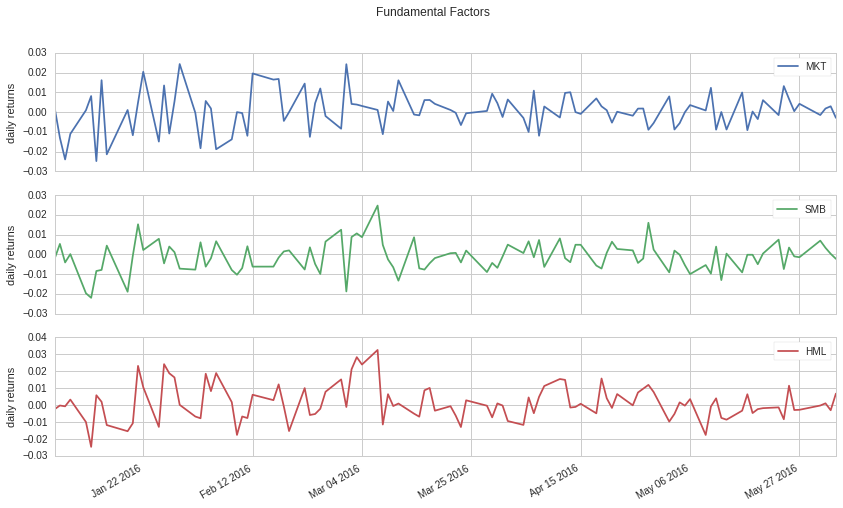

In [7]:
ax = F.plot(subplots=True, title="Fundamental Factors")
ax[0].set(ylabel = "daily returns")
ax[1].set(ylabel = "daily returns")
ax[2].set(ylabel = "daily returns")
plt.show()

Running the multi-linear regression on the fundamental factors, we can obtain the corresponding factor exposure for each asset.

In [8]:
# factor exposure
B = pd.DataFrame(index=assets, dtype=np.float32)
# residual
epsilon = pd.DataFrame(index=R.index, dtype=np.float32)

In [9]:
x = sm.add_constant(F)

for i in assets:
    y = R.loc[:,i]
    y_inlier = y[np.abs(y - y.mean())<=(3*y.std())]
    x_inlier = x[np.abs(y - y.mean())<=(3*y.std())]
    result = regression.linear_model.OLS(y_inlier, x_inlier).fit() 

    epsilon.loc[:,i] = result.resid
    B.loc[i,"MKT_beta"] = result.params[1]
    B.loc[i,"SMB_beta"] = result.params[2]
    B.loc[i,"HML_beta"] = result.params[3]  
 

The factor exposures are shown as follows. 

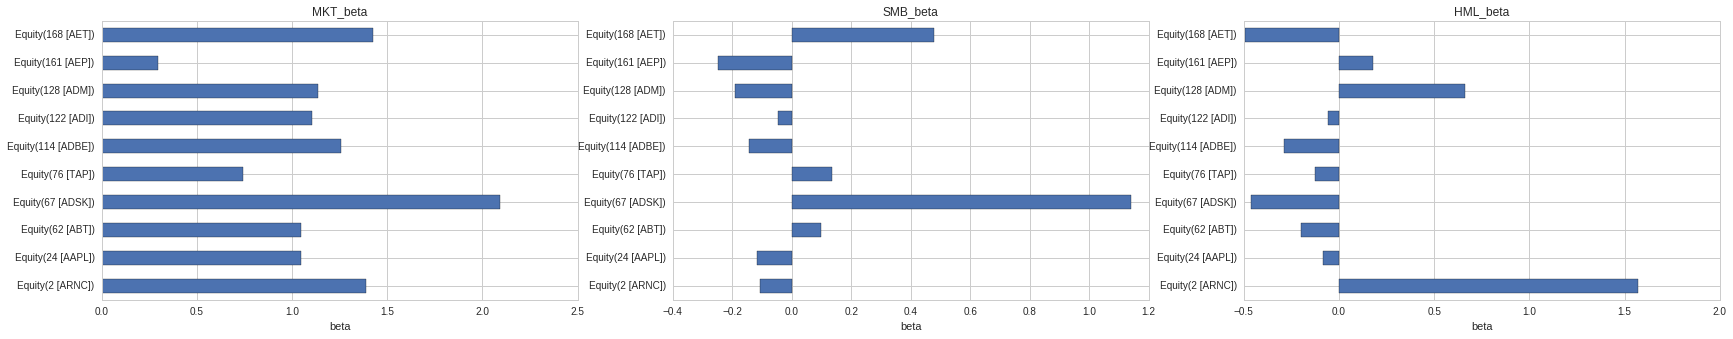

In [10]:
fig,axes = plt.subplots(1,3)
ax1,ax2,ax3 =axes

B.iloc[0:10,0].plot.barh(ax=ax1, figsize=[29,5], title=B.columns[0])
B.iloc[0:10,1].plot.barh(ax=ax2, figsize=[29,5], title=B.columns[1])
B.iloc[0:10,2].plot.barh(ax=ax3, figsize=[29,5], title=B.columns[2])

ax1.set(xlabel='beta')
ax2.set(xlabel='beta')
ax3.set(xlabel='beta')
plt.show()

In [11]:
B.loc[symbols('AAPL'),:]

MKT_beta    1.046191
SMB_beta   -0.116198
HML_beta   -0.086110
Name: Equity(24 [AAPL]), dtype: float64

#### Summary of the Setup:
1. returns of assets in universe: `R`
2. fundamental factors: `F`
3. Exposures of these fundamental factors: `B`
4. 

In [12]:
F.head(3)

,MKT,SMB,HML
2016-01-05 00:00:00+00:00,0.002090,-0.002069,-0.002346
2016-01-06 00:00:00+00:00,-0.013010,0.005314,-0.000184
2016-01-07 00:00:00+00:00,-0.023941,-0.004065,-0.000666


In [13]:
B.head(3)

,MKT_beta,SMB_beta,HML_beta
Equity(2 [ARNC]),1.387909,-0.106336,1.569786
Equity(24 [AAPL]),1.046191,-0.116198,-0.086110
Equity(62 [ABT]),1.045583,0.098370,-0.200113


### 1. What proportion of the variance of my portfolio comes from common risk factors?

The portfolio variance can be computed by 
  
  $$\sigma^2 = \text{common factor variance} + \text{specific variance}$$

where:


- common factor variance $=$  $hBVB^{\top}h^{\top}$


- specific variance $=$ $hDh^{\top}$


- $B$ is the matrix of factor exposures of $n$ assets to the factors, 


- $V$ is the covariance matrix of factors


- $D$ is specific variance


- $h$ is the vector of portfolio weights for $n$ assets,



#### Compute common factor variance:


In [14]:
# suppose the portfolio is an equally weighted portfolio
h = np.ones([1,R.shape[1]])/R.shape[1]

In [15]:
def compute_common_factor_variance(factors, factor_exposures, h):   
    B = np.asarray(factor_exposures)
    F = np.asarray(factors)
    V = np.asarray(factors.cov())
    
    return h.dot(B.dot(V).dot(B.T)).dot(h.T)

common_factor_variance = compute_common_factor_variance(F, B, h)
common_factor_variance

array([[ 0.00011182]])

In [16]:
def compute_specific_variance(epsilon, h):       
    
    D = np.diag(np.asarray(epsilon.var())) * epsilon.shape[0] / (epsilon.shape[0]-1)

    return h.dot(D).dot(h.T)

specific_variance = compute_specific_variance(epsilon, h)
specific_variance

array([[  5.21258877e-07]])

####  The proportion of the variance of my portfolio comes from common risk factors is 


$$\frac{\text{common factor variance}}{\text{common factor variance + specific variance}}$$.

In [17]:
common_factor_variance/(common_factor_variance + specific_variance)

array([[ 0.99536025]])

### 2. How to limit the risk?

Use optimization to adjust the allocations of the portfolio!

The optimization problem can be constructed as:

\begin{array}{ll} \mbox{$\text{minimize/maximum}$}_{w} & \text{objective function}\\
\mbox{subject to} & {\bf 1}^T w = 1, \quad f=B^Tw\\
& w \in {\cal W}, \quad f \in {\cal F},
\end{array}
where the variable $w$ is the vector of allocations, the variable $f$ is weighed factor exposures, and  the variable ${\cal F}$ gives $f$ constraints.





The objective function is the result of an attempt to express a business goal in mathematical terms. For example, it can be sharpe ratio or volatility. 

The varible we would like to solve in this optimization is $w$. To 

In [18]:
w_0 = np.random.rand(R.shape[1])
w_0 = w_0/np.sum(w_0)

The variable $f$ is weighed factor exposures of the porfolio, and its size equals to the size of factors.  Applying different allocation $w$ to portfolio, the $f$ changes.

In [19]:
f = B.T.dot(w_0)
f

MKT_beta    1.080142
SMB_beta    0.070365
HML_beta    0.164351
dtype: float64

The variable ${\cal F}$ can be set as a vector to bound the weighed factor exposures of the porfolio $f$. For example, $\cal F$ can be set as $[1,1,1]$. It means the maximum factor exposures of the porfolio $f$ cannot be greater than 1, and the objective function will search its best solution $w$ under this condition.

A concrete example can be found in [cvx course: portfolio optimization](http://nbviewer.jupyter.org/github/cvxgrp/cvx_short_course/blob/master/applications/portfolio_optimization.ipynb).

### 3. Performance attribution: where does the return/PNL come from?

Let us use a sample algo in quantopian community as an example to show how to analyze return/pnl using the outputs of factor model.

In [20]:
bt_wsj = get_backtest('5991432853a96650f7624b77')

100% Time: 0:00:01|###########################################################|


In [21]:
algo = bt_wsj.pyfolio_positions
algo.index.name = None
holdings = algo.drop(labels='cash', axis=1)
holdings = holdings.fillna(0)
for i,idx in enumerate(holdings.columns):
    holdings = holdings.rename(index=None, columns=({holdings.columns[i]
                                                    :holdings.columns[i].split('-', 1)[1]}))
holdings.columns = symbols(holdings.columns.astype('int'))

We could analyze this algo's performance attribution on any day.

In [22]:
example_date = '2016-01-06'

In [23]:
def stocks_hold(P, date):
    PP = P.loc[date,:]
    return pd.DataFrame(PP[PP !=0])

stock_holdings = stocks_hold(holdings, example_date)

total_long_position = stock_holdings[stock_holdings>0].dropna().sum()
print "total long position at {} is: ${}".format(example_date, total_long_position.iloc[0])

total_short_position = stock_holdings[stock_holdings<0].dropna().sum()
print "total short position at {} is: ${}".format(example_date, total_short_position.iloc[0])


print "holdings at at {} is: ".format(example_date)
df_1 = stock_holdings.copy()
df_1.head()

total long position at 2016-01-06 is: $476474.764
total short position at 2016-01-06 is: $-489388.502
holdings at at 2016-01-06 is: 


,2016-01-06 00:00:00+00:00
Equity(2 [ARNC]),-2992.80
Equity(270 [AKRX]),-3465.90
Equity(301 [ALKS]),-3302.20
Equity(337 [AMAT]),-3226.86
Equity(351 [AMD]),-3015.00


In [24]:
def fundamental_factor_returns(universe_returns, factors, exposures, date):
    
    performance_attribution = pd.DataFrame(index = universe_returns.columns)

    performance_attribution.loc[:,'PnL'] = universe_returns.loc[date,:]

    performance_attribution.loc[:,"MKT explained"] = factors.loc[date,"MKT"] * exposures.loc[:,"MKT_beta"]
    performance_attribution.loc[:,"SMB explained"] = factors.loc[date,"SMB"] * exposures.loc[:,"SMB_beta"]
    performance_attribution.loc[:,"HML explained"] = factors.loc[date,"HML"] * exposures.loc[:,"HML_beta"]
        
    return performance_attribution

performance_attribution = fundamental_factor_returns(R, F, B, example_date)

In [25]:
def factor_returns_algorithm(date, universe_returns, factors, exposures, holdings):
    
    analysis_ff = fundamental_factor_returns(universe_returns, factors, exposures, date)
    
    stocks_holdings = stocks_hold(holdings, date)
    
    L = list(stocks_hold(holdings,date).index)
    
    ph_factor_return= analysis_ff.loc[symbols(L),:]
    
    ph_factor_return_dollar = ph_factor_return.mul(np.asarray(stocks_holdings.iloc[:,0]),axis = 0)
      
    return (ph_factor_return,ph_factor_return_dollar)

In [26]:
(ph_factor_return,ph_factor_return_dollar) = factor_returns_algorithm(example_date, R, 
                                                                      F, B,
                                                                      holdings)
print "Total factor returns of the portfolio in dollar on {} are: ".format(example_date)
pd.DataFrame(ph_factor_return_dollar.sum(), columns=[example_date])

Total factor returns of the portfolio in dollar on 2016-01-06 are: 


,2016-01-06
PnL,-5783.512962
MKT explained,-1375.121211
SMB explained,-67.995615
HML explained,-28.549844
